# Quora Questions (LSTM)
Kunlun Liu

Blog Link
https://medium.com/@kunlun.liu/quora-similar-questions-dd8fb5398bfa

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import keras.layers as lyr
from keras.models import Model
from keras.models import Sequential
from keras import regularizers

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('D:\PyCharm Files\quora\\train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

In [3]:
df_test = pd.read_csv('D:\PyCharm Files\quora\\test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

In [4]:
df_all = pd.concat((df_train, df_test))
df_all['question1'].fillna('', inplace=True)
df_all['question2'].fillna('', inplace=True)

In [5]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))
other_index = len(counts_vectorizer.vocabulary_)

In [6]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [7]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [8]:
df_all = df_all.sample(1000) # Just for debugging

In [9]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=19)

# Long short-term memory (LSTM) model

In [104]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization

MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300
words_embedding_layer = lyr.Embedding(X1_train.max() + 1, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,trainable=False)
seq_embedding_layer = lyr.LSTM(10, activation='tanh',recurrent_dropout=0.5,kernel_regularizer=regularizers.l1(0.01))
seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = concatenate([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

drop_out_layer = lyr.Dropout(0.5)(merge_layer)
normal_layer = BatchNormalization()(drop_out_layer)

dense1_layer = lyr.Dense(6, activation="tanh")(normal_layer)
normal_layer1 = BatchNormalization()(dense1_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(normal_layer1)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 30, 300)      3000000     input_53[0][0]                   
                                                                 input_54[0][0]                   
__________________________________________________________________________________________________
lstm_27 (LSTM)                  (None, 10)           12440       embedding_27[0][0]               
          

In [105]:
history = model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=1024, epochs=100, verbose=1)

Train on 106 samples, validate on 46 samples
Epoch 1/100
106/106 [==============================] - 7s 64ms/step - loss: 8.8612 - acc: 0.5377 - val_loss: 8.5476 - val_acc: 0.5217
Epoch 2/100
106/106 [==============================] - 0s 316us/step - loss: 8.6133 - acc: 0.5566 - val_loss: 8.4472 - val_acc: 0.4783
Epoch 3/100
106/106 [==============================] - 0s 331us/step - loss: 8.3217 - acc: 0.6038 - val_loss: 8.2945 - val_acc: 0.4783
Epoch 4/100
106/106 [==============================] - 0s 378us/step - loss: 8.2901 - acc: 0.5660 - val_loss: 8.1469 - val_acc: 0.4565
Epoch 5/100
106/106 [==============================] - 0s 350us/step - loss: 8.0127 - acc: 0.6509 - val_loss: 8.0202 - val_acc: 0.5000
Epoch 6/100
106/106 [==============================] - 0s 322us/step - loss: 7.8182 - acc: 0.6887 - val_loss: 7.8443 - val_acc: 0.5000
Epoch 7/100
106/106 [==============================] - 0s 350us/step - loss: 7.6984 - acc: 0.6415 - val_loss: 7.6751 - val_acc: 0.4783
Epoch 8/100

Epoch 61/100
106/106 [==============================] - 0s 303us/step - loss: 0.8736 - acc: 0.9623 - val_loss: 1.4412 - val_acc: 0.7174
Epoch 62/100
106/106 [==============================] - 0s 407us/step - loss: 0.8142 - acc: 1.0000 - val_loss: 1.3493 - val_acc: 0.7609
Epoch 63/100
106/106 [==============================] - 0s 303us/step - loss: 0.7630 - acc: 1.0000 - val_loss: 1.2858 - val_acc: 0.6957
Epoch 64/100
106/106 [==============================] - 0s 284us/step - loss: 0.7318 - acc: 1.0000 - val_loss: 1.2555 - val_acc: 0.6957
Epoch 65/100
106/106 [==============================] - 0s 359us/step - loss: 0.7038 - acc: 0.9906 - val_loss: 1.3097 - val_acc: 0.6957
Epoch 66/100
106/106 [==============================] - 0s 350us/step - loss: 0.6762 - acc: 0.9906 - val_loss: 1.2338 - val_acc: 0.7609
Epoch 67/100
106/106 [==============================] - 0s 359us/step - loss: 0.6438 - acc: 0.9906 - val_loss: 1.1912 - val_acc: 0.7174
Epoch 68/100
106/106 [==========================

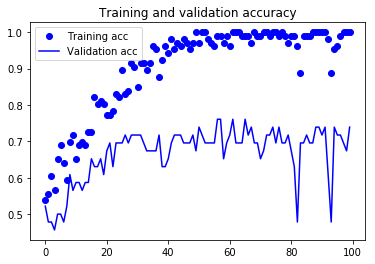

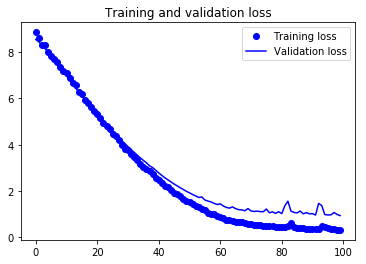

In [106]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model Evaluation

In [117]:
model.evaluate(x=[X1_val, X2_val], y=y_val, batch_size=1024, verbose=1, sample_weight=None, steps=None)

46/46 [==============================] - 0s 2ms/step


[0.93247699737548828, 0.73913043737411499]

In [118]:
preds = model.predict([X1_val, X2_val], batch_size=8192, verbose=1)


46/46 [==============================] - 5s 102ms/step


In [123]:
preds1 = []
for i in range(len(preds)):
    if preds[i][0] < 0.5:
        preds1.append(1)
    else:
        preds1.append(0)
np.array(preds1)

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [120]:
y_val

array([ 0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.])